In [75]:
import pandas as pd, numpy as np, xgboost as xgb, shap, matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# =============================
# 1. Load & Clean Dataset
# =============================
data = pd.read_csv('dataset.csv', parse_dates=['Date'], index_col='Date')
data.fillna(method='ffill', inplace=True)
data.dropna(inplace=True)

# =============================
# 2. Define Target & Features
# =============================
target = 'house_price_index'
macro_features = ['gdp', 'mortgage_rate', 'employment_rate', 'ppi_res', 'm3', 'cci',
                  'delinquency_rate', 'hcai']

# =============================
# 3. Time-Series Feature Engineering
# =============================
# Lag features
for lag in range(1, 13):
    data[f'hpi_lag_{lag}'] = data[target].shift(lag)

# Rolling statistics
for w in [3, 6, 12]:
    data[[f'hpi_rolling_{stat}_{w}' for stat in ['mean', 'std', 'min', 'max']]] = \
        data[target].rolling(w).agg(['mean', 'std', 'min', 'max'])

# Percentage change
for p in [1, 3, 6, 12]:
    data[f'hpi_pct_change_{p}'] = data[target].pct_change(p)

# Drop rows with NaN after feature engineering
data.dropna(inplace=True)

# =============================
# 4. Prepare Final Features & Scale
# =============================
all_features = macro_features + [col for col in data.columns if col not in macro_features + [target]]
X, y = data[all_features], data[target]
X_scaled = MinMaxScaler().fit_transform(X)

# =============================
# 5. Define Custom Loss and Metric
# =============================
def percentage_error(preds, dtrain):
    y_true = dtrain.get_label()
    return 'percentage_error', np.mean(np.abs((preds - y_true) / y_true))

def custom_obj(preds, dtrain):
    y_true = dtrain.get_label()
    grad = (preds - y_true) + 0.5 * (preds - y_true) / (np.abs(y_true) + 1e-6)
    hess = np.ones_like(preds) + 0.5 / (np.abs(y_true) + 1e-6)
    return grad, hess



<ipython-input-75-1379c9ed2cb7>:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv('dataset.csv', parse_dates=['Date'], index_col='Date')
<ipython-input-75-1379c9ed2cb7>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
/usr/local/lib/python3

In [ ]:
# =============================
# 6. Define XGBoost Parameters
# =============================

params = {
    'learning_rate': 0.03,         # Reasonable rate for convergence
    'max_depth': 3,                # Low depth to prevent overfitting on time-series
    'subsample': 0.6,              # Random sampling for regularization
    'colsample_bytree': 0.6,       # Prevent overfitting by using fewer features per tree
    'min_child_weight': 10,        # Minimum data per leaf to avoid noise fitting
    'reg_alpha': 1.0,              # L1 regularization
    'reg_lambda': 2.0,             # L2 regularization
    'objective': 'reg:squarederror',  # Base loss, overridden by custom_obj
    'n_estimators': 1000,
    'early_stopping_rounds': 50,
    'random_state': 42
}


# =============================
# 7. Time-based Train-Test Split
# =============================
#split = int(len(data) * 0.8)
#split = int(len(data) * 0.7)
split = int(len(data) * 0.6)
dtrain = xgb.DMatrix(X_scaled[:split], label=y[:split])
dtest = xgb.DMatrix(X_scaled[split:], label=y[split:])

# =============================
# 8. Train XGBoost Model
# =============================
final_model = xgb.train(params, dtrain, params['n_estimators'],
                        [(dtrain, 'train'), (dtest, 'test')],
                        obj=custom_obj, feval=percentage_error, verbose_eval=False)


In [76]:
# =============================
# 9. Evaluation Metrics
# =============================
def evaluate(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mpe = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    within_10 = (np.abs((y_true - y_pred)/y_true) < 0.10).mean()*100
    print(f'{name} → RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}, MPE: {mpe:.2f}%, ±10%: {within_10:.2f}%')

y_train_pred = final_model.predict(dtrain)
y_test_pred = final_model.predict(dtest)
evaluate(y[:split], y_train_pred, "Train")
evaluate(y[split:], y_test_pred, "Test")



Train → RMSE: 0.214, MAE: 0.156, R²: 1.000, MPE: 0.12%, ±10%: 100.00%
Test → RMSE: 39.120, MAE: 23.699, R²: -0.123, MPE: 9.82%, ±10%: 59.29%


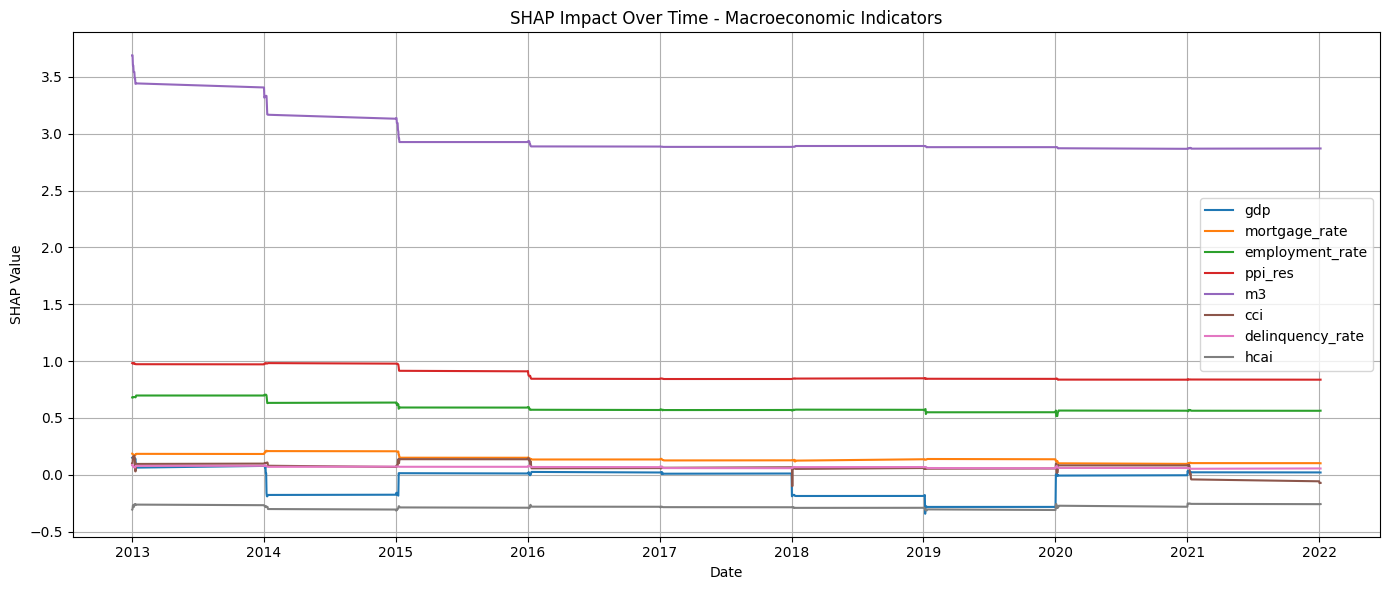

In [77]:
# =============================
# 10. SHAP Analysis (Macroeconomic)
# =============================
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_scaled[split:])
shap_df = pd.DataFrame(shap_values, columns=X.columns, index=y[split:].index)

plt.figure(figsize=(14, 6))
for feature in macro_features:
    if feature in shap_df.columns:
        plt.plot(shap_df.index, shap_df[feature], label=feature)
plt.title("SHAP Impact Over Time - Macroeconomic Indicators")
plt.xlabel("Date"); plt.ylabel("SHAP Value")
plt.legend(); plt.grid(); plt.tight_layout()
plt.show()

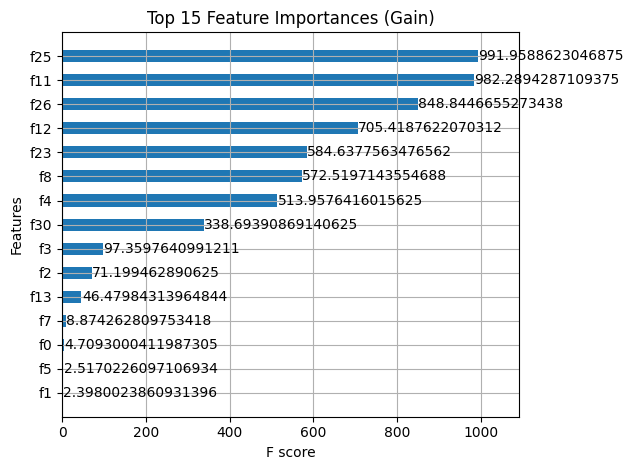

In [78]:
# =============================
# 11. Feature Importance Plot
# =============================
xgb.plot_importance(final_model, max_num_features=15, importance_type='gain', height=0.5)
plt.title('Top 15 Feature Importances (Gain)')
plt.tight_layout()
plt.show()

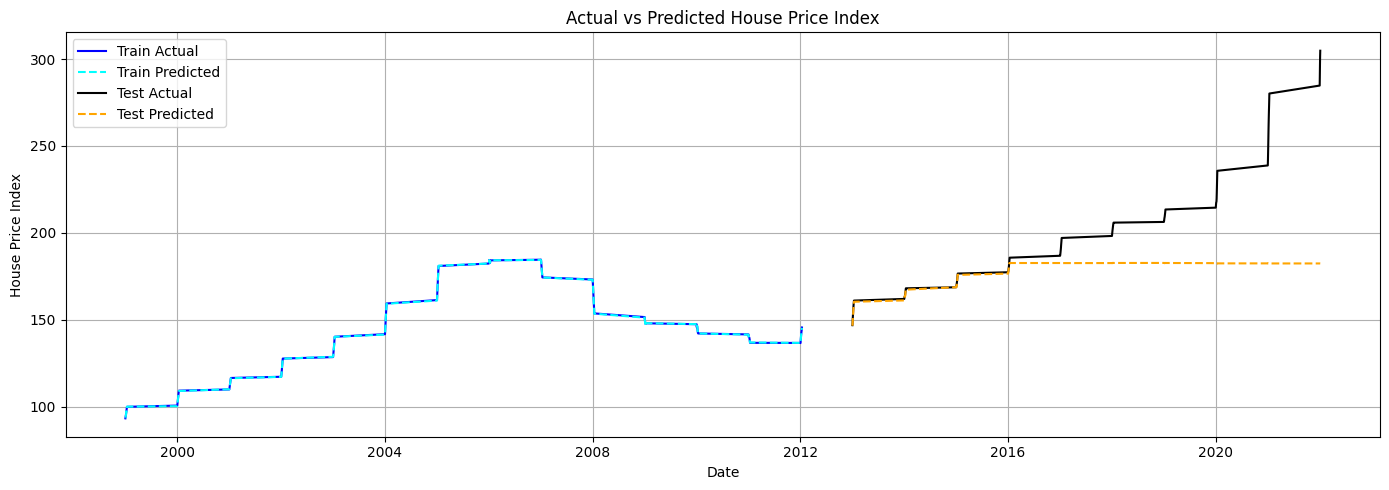

In [79]:
# =============================
# 12. Actual vs Predicted Plot
# =============================
plt.figure(figsize=(14, 5))
plt.plot(y.index[:split], y[:split], label='Train Actual', color='blue')
plt.plot(y.index[:split], y_train_pred, label='Train Predicted', linestyle='--', color='cyan')
plt.plot(y.index[split:], y[split:], label='Test Actual', color='black')
plt.plot(y.index[split:], y_test_pred, label='Test Predicted', linestyle='--', color='orange')
plt.title("Actual vs Predicted House Price Index")
plt.xlabel("Date"); plt.ylabel("House Price Index")
plt.legend(); plt.grid(); plt.tight_layout()
plt.show()
